## This uses transfer learning on a pre-trained classifier to build an Alpaca Classifier

 It uses MobileNetV2 which has been pre-trained on ImageNet, a dataset containing over 14 million images and 1000 classes.

## 1. Packages

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
import tensorflow.keras.layers as tfl

from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomRotation

In [3]:
#Generate dataset from images in the dataset folder

BATCH_SIZE = 32
IMG_SIZE = (160, 160)
directory = "dataset/"
# Create training and validation set. Use the same seed to avoid image overlap
train_dataset = image_dataset_from_directory(directory,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE,
                                             validation_split=0.2,
                                             subset='training',
                                             seed=42)
validation_dataset = image_dataset_from_directory(directory,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE,
                                             validation_split=0.2,
                                             subset='validation',
                                             seed=42)

Found 327 files belonging to 2 classes.
Using 262 files for training.
Found 327 files belonging to 2 classes.
Using 65 files for validation.


In [4]:
#view class names
class_names = train_dataset.class_names
class_names

['alpaca', 'not alpaca']

## Pre-fetch data and Pre-process


Using prefetch() prevents a memory bottleneck that can occur when reading from disk. It sets aside some data and keeps it ready for when it's needed, by creating a source dataset from the input data, applying a transformation to preprocess it, then iterating over the dataset one element at a time. 

In [5]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE) #choose number of elements to pre-fetch automatically

In [6]:
# data will need to be augmented to increase size of dataset

def data_augmenter():
    '''
    Create a Sequential model composed of 2 layers.
    layer 1 - causes flip on horinzotal axis
    layer 2 -causes rotation
    Returns:
        tf.keras.Sequential
    '''
    
    data_augmentation = tf.keras.models.Sequential();
    data_augmentation.add(RandomFlip('horizontal'))
    data_augmentation.add(RandomRotation(0.2))
   
    
    return data_augmentation

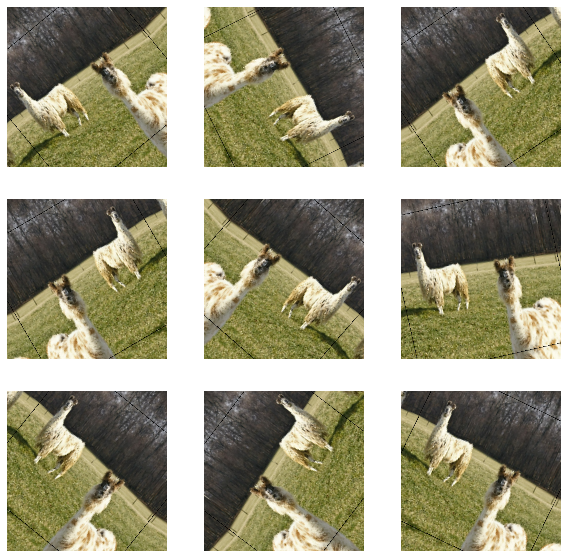

In [7]:
data_augmentation = data_augmenter()

for image, _ in train_dataset.take(1):
    plt.figure(figsize=(10, 10))
    first_image = image[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0] / 255)
        plt.axis('off')

When using a pretrained model, it's best to reuse the weights it was trained on. MobileNetV2 is already part of Keras and we can access it. Since we're using a pre-trained model that was trained on the normalization values [-1,1], it's best practice to reuse that standard with tf.keras.applications.mobilenet_v2.preprocess_input.

In [8]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
#The preprocess_input function is meant to adequate the image to the format the model requires.
#Some models use images with values ranging from 0 to 1. Others from -1 to +1
# We use the values that were used for the original mobilenetv2. 
#we can get them from the applications.mobilenet_v2.preprocess_input

## Base Model to Alpaca model

Given the MobileNetV2 base model, the top layers are used for classification. Inorder to convert it to an alpaca classifier, we would exclude these top layers from our base model and then build our model from there

Training will be done as follows:
- Delete the top layer (the classification layer)
- Set include_top in base_model as False
- Add a new classifier layer
- Train only one layer by freezing the rest of the network
- A single neuron is enough to solve a binary classification problem.
- Freeze the base model and train the newly-created classifier layer
- Set base model.trainable=False to avoid changing the weights and train only the new layer
- Set training in base_model to False to avoid keeping track of statistics in the batch norm l

In [9]:
def alpaca_model(image_shape=IMG_SIZE, data_augmentation=data_augmenter()):
    ''' Define a tf.keras model for binary classification out of the MobileNetV2 model
    Arguments:
        image_shape -- Image width and height
        data_augmentation -- data augmentation function
    Returns:
    Returns:
        tf.keras.model
    '''
    
    
    input_shape = image_shape + (3,) # image shape plus 3 dimensions. In this case 160,160,3 (For the colour channels).
    
   
    #This is the base model of the mobileNetV2.Notice how the top layer is excluded
    base_model = tf.keras.applications.MobileNetV2(input_shape=input_shape,
                                                   include_top=False, # <== Important!!!!
                                                   weights='imagenet') # From imageNet
    
    # freeze the base model by making it non trainable
    base_model.trainable = False 

    # create the input layer (Same as the imageNetv2 input size)
    inputs = tf.keras.Input(shape=input_shape) 
    
    # apply data augmentation to the inputs
    x = data_augmentation(inputs)
    
    # data preprocessing using the same weights the model was trained on
    
    x = preprocess_input(x) 
    
    # set training to False to avoid keeping track of statistics in the batch norm layer
    x = base_model(x, training=False) 
    
    # -----------------add the new Binary classification layers------------------------------
    # use global avg pooling to summarize the info in each channel
    #Global Average Pooling is a pooling operation designed to replace fully connected layers in classical CNNs. 
    #The idea is to generate one feature map for each corresponding category of the classification task in the last
    #mlpconv layer. 
    #Instead of adding fully connected layers on top of the feature maps, 
    #we take the average of each feature map, and the resulting vector is fed directly into the softmax layer.
    
    x = tf.keras.layers.GlobalAveragePooling2D()(x) 
    
    # include dropout with probability of 0.2 to avoid overfitting
    x = tf.keras.layers.Dropout(0.2)(x)
        
    # use a prediction layer with one neuron (as a binary classifier only needs one)
    outputs = tf.keras.layers.Dense(1)(x)
    
  
    
    model = tf.keras.Model(inputs, outputs)
    
    return model

## Create model

In [10]:
model2 = alpaca_model(IMG_SIZE, data_augmentation)

In [11]:
base_learning_rate = 0.001
model2.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [12]:
initial_epochs = 5
history = model2.fit(train_dataset, validation_data=validation_dataset, epochs=initial_epochs)

Epoch 1/5
9/9 [==============================] - 8s 919ms/step - loss: 0.7134 - accuracy: 0.5802 - val_loss: 0.5979 - val_accuracy: 0.6000
Epoch 2/5
9/9 [==============================] - 7s 786ms/step - loss: 0.5797 - accuracy: 0.7137 - val_loss: 0.4931 - val_accuracy: 0.6462
Epoch 3/5
9/9 [==============================] - 8s 927ms/step - loss: 0.4951 - accuracy: 0.7328 - val_loss: 0.4260 - val_accuracy: 0.6615
Epoch 4/5
9/9 [==============================] - 6s 709ms/step - loss: 0.4602 - accuracy: 0.7214 - val_loss: 0.3640 - val_accuracy: 0.7538
Epoch 5/5
9/9 [==============================] - 7s 754ms/step - loss: 0.4091 - accuracy: 0.7977 - val_loss: 0.3217 - val_accuracy: 0.8000


## Fine tune model

 This means we should unfreeze the final layers and re-run the optimizer with a smaller learning rate, while keeping all the other layers frozen.

In [13]:
base_model = model2.layers[4]
base_model.trainable = True
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 120



# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False
    
# Define a BinaryCrossentropy loss function. Use from_logits=True
loss_function=tf.keras.losses.BinaryCrossentropy(from_logits=True)
# Define an Adam optimizer with a learning rate of 0.1 * base_learning_rate
optimizer = tf.keras.optimizers.Adam(lr= 0.1 *base_learning_rate)
# Use accuracy as evaluation metric
metrics=['accuracy']



model2.compile(loss=loss_function,
              optimizer = optimizer,
              metrics=metrics)

Number of layers in the base model:  155


In [14]:
fine_tune_epochs = 5
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model2.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 5/10
9/9 [==============================] - 9s 991ms/step - loss: 0.6331 - accuracy: 0.7519 - val_loss: 0.2947 - val_accuracy: 0.8154
Epoch 6/10
9/9 [==============================] - 8s 902ms/step - loss: 0.3124 - accuracy: 0.8473 - val_loss: 0.1353 - val_accuracy: 0.9846
Epoch 7/10
9/9 [==============================] - 7s 781ms/step - loss: 0.3914 - accuracy: 0.8053 - val_loss: 0.1646 - val_accuracy: 0.8769
Epoch 8/10
9/9 [==============================] - 8s 891ms/step - loss: 0.2508 - accuracy: 0.8931 - val_loss: 0.0997 - val_accuracy: 0.9538
Epoch 9/10
9/9 [==============================] - 8s 901ms/step - loss: 0.1907 - accuracy: 0.9237 - val_loss: 0.0990 - val_accuracy: 0.9538
Epoch 10/10
9/9 [==============================] - 8s 858ms/step - loss: 0.1514 - accuracy: 0.9427 - val_loss: 0.0683 - val_accuracy: 0.9846


# That's it, model now has a high accuracy!